# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1mPsJAzuIp_XzpMpuLREqTdlU-DdLEumX

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
filename = '/content/gdrive/MyDrive/Colab Notebooks/Lab5 data/sms+spam+collection/SMSSpamCollection'

In [53]:
!pip install -U torchtext==0.6.0

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [55]:
#use <tab> as the delimiter for .split()
for line in open(filename):
    if line.split()[0] == 'ham':
        print('Non-Spam message:', line[4:])
        print('Non-Spam label is:', line.split()[0])
        break
for line in open(filename):
    if line.split()[0] == 'spam':
        print('Spam Message:', line[5:])
        print('Spam label is:', line.split()[0])
        break

Non-Spam message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Non-Spam label is: ham
Spam Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Spam label is: spam


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [56]:
spam_counter = 0
ham_counter = 0
for line in open(filename):
    #use same delimiter
    if line.split()[0] == 'ham':
        ham_counter += 1
    elif line.split()[0] == 'spam':
        spam_counter += 1
print('there are', ham_counter, 'non-spam messages')
print('there are', spam_counter, 'spam messages')

there are 4827 non-spam messages
there are 747 spam messages


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [57]:
# When using characters as tokens, there are only the alphanumeric and special symbols as possible tokens, which will
# require less memory/storage. Also, by using characters as tokens, special characters and spaces can be taken into account
# whereas with words as tokens, that would be much more convoluted.

# Disadvantages includes having to use more tokens to reconstruct a sentence, which will be more complex to deal with.
# Additionally, using individual characters as tokens is more complex, which will most likely result in a lower accuracy.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [58]:
import torchtext

text_field = torchtext.data.Field(sequential=True,
                       tokenize=lambda x: x,
                       include_lengths=True,
                       batch_first = True,
                       use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))
fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(filename,
                                        "tsv",
                                        fields)
#SPLIT DATASET INTO 60-20-20
train_data, valid_data, test_data = dataset.split([0.6, 0.2, 0.2], True)


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [59]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6

# having a balanced training set is very important in removing potential classification biases. For example,
# if the model is trained on more "non-spam" messages, it will be better suited to recognize a "non-spam" message.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [60]:
text_field.build_vocab(train_data)
print(len(text_field.vocab.itos))
#text_field.vocab.stoi --> maps string token to integer index
#text_field.vocab.itos --> maps index to back to string token

109


### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [61]:
# <unk> are the unknown text tokens in the SMS text message.
# <pad> represents the padding tokens, which will increase the length of the character sequence to the maximal character length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [62]:
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [63]:
batch_count = 1
for batch in train_iter:
  if batch_count <= 10:
    print('Batch', batch_count, 'has maximum length:', int(batch.sms[1][0])) #this is because batch.sms[1] is the lengths of the tokens (with padding) organized in descending order.
    #to find amount of padding, calculate the difference between the padded messages (batch.sms[1]) and non-padded messages (batch.sms[0])
    #print(batch.sms[1])
    padding = 0
    for msg in range(len(batch.sms[1])):
      padding += (batch.sms[1][0] - batch.sms[1][msg])
    print('Batch', batch_count, 'has', int(padding), 'padding.')
    #print(batch.label)
    batch_count += 1
  else: break

Batch 1 has maximum length: 156
Batch 1 has 25 padding.
Batch 2 has maximum length: 145
Batch 2 has 4 padding.
Batch 3 has maximum length: 153
Batch 3 has 28 padding.
Batch 4 has maximum length: 155
Batch 4 has 5 padding.
Batch 5 has maximum length: 119
Batch 5 has 64 padding.
Batch 6 has maximum length: 152
Batch 6 has 10 padding.
Batch 7 has maximum length: 158
Batch 7 has 16 padding.
Batch 8 has maximum length: 161
Batch 8 has 21 padding.
Batch 9 has maximum length: 35
Batch 9 has 34 padding.
Batch 10 has maximum length: 154
Batch 10 has 12 padding.


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [64]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [65]:
#Build RNN:
input_size = len(text_field.vocab.itos)
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_class):
    self.name = "RNN"
    super(RNN, self).__init__()
    # one-hot encoding with length of input
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)
  # forward passing function
  def forward(self, x):
    # Look-up the embeddings
    x = self.emb[ x]
    # Set the initial hidden states
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, __ = self.rnn(x, h0)
    # Pass the output of the last step to the classifier
    return self.fc(out[:,-1,:])

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [66]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    #from 1h), load data:
    data_loader = torchtext.data.BucketIterator(data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    corr, tot = 0, 0
    for message, labels in data_loader:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        corr += pred.eq(labels.view_as(pred)).sum().item()
        tot += labels.shape[0]
    return corr / tot

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [67]:
import matplotlib.pyplot as plt
def train(model, train_data, valid_data, batch_size, num_epochs=5, lr=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train_losses, valid_losses, train_acc, valid_acc, iters = [], [], [], [], []
  # LOAD DATA
  train_loader = torchtext.data.BucketIterator(train_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
  valid_loader = torchtext.data.BucketIterator(valid_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

  for epoch in range(num_epochs):
    #train
    for msgs, labels in train_loader:
      optimizer.zero_grad()
      pred = model(msgs[0])
      loss = criterion(pred, labels)
      loss.backward()
      optimizer.step()
    #valid
    for msgs, labels in valid_loader:
      pred = model(msgs[0])
      loss = criterion(pred, labels)
    #get accuracy
    iters.append(epoch)
    train_acc.append(get_accuracy(model, train_data))
    train_losses.append(float(loss))
    valid_acc.append(get_accuracy(model, valid_data))
    valid_losses.append(float(loss))
    print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[-1],
                   train_losses[-1],
                   valid_acc[-1],
                   valid_losses[-1]))
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)

  #plot
  plt.title("Training Curve")
  plt.plot(iters, train_losses, label="Train")
  plt.plot(iters, valid_losses, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  #Accuracy Curve
  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, valid_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(valid_acc[-1]))

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: Train acc: 0.5317526115072128, Train loss: 0.4953348636627197 |Validation acc: 0.8717488789237668, Validation loss: 0.4953348636627197
Epoch 2: Train acc: 0.9011772508705024, Train loss: 0.35051101446151733 |Validation acc: 0.9434977578475336, Validation loss: 0.35051101446151733
Epoch 3: Train acc: 0.9059857403415685, Train loss: 0.12215471267700195 |Validation acc: 0.9524663677130045, Validation loss: 0.12215471267700195
Epoch 4: Train acc: 0.774995854750456, Train loss: 0.3258305788040161 |Validation acc: 0.9085201793721973, Validation loss: 0.3258305788040161
Epoch 5: Train acc: 0.9008456309069806, Train loss: 0.10619805008172989 |Validation acc: 0.9381165919282511, Validation loss: 0.10619805008172989
Epoch 6: Train acc: 0.927375227988725, Train loss: 0.0847209021449089 |Validation acc: 0.9587443946188341, Validation loss: 0.0847209021449089
Epoch 7: Train acc: 0.9333443873321174, Train loss: 0.15237295627593994 |Validation acc: 0.9533632286995516, Validation loss: 0.1523

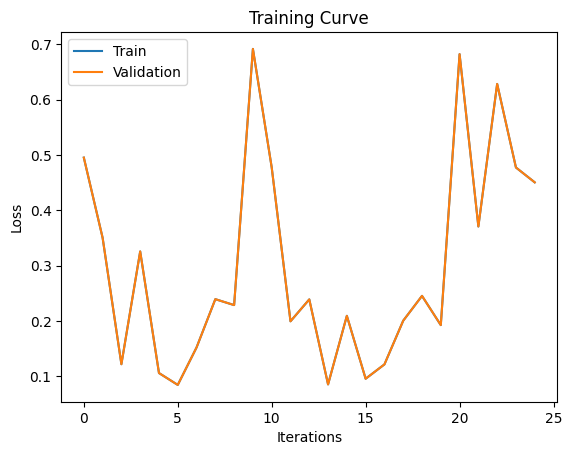

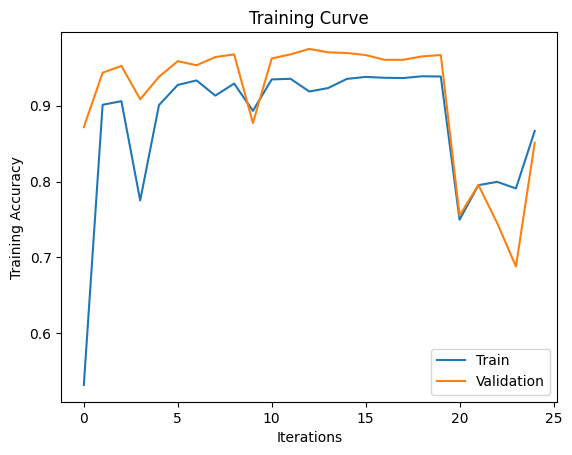

Final Training Accuracy: 0.8666887746642348
Final Validation Accuracy: 0.8511210762331839


In [68]:
model = RNN(input_size, 100, 2)
train(model, train_data, valid_data, batch_size = 64, num_epochs=25, lr=5e-4)

In [69]:
#use this suggestion given in section 2:

#out, _ = self.rnn(x)
#self.fc(torch.max(out, dim=1)[0])

class newRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_class):
    self.name = "newRNN"
    super(newRNN, self).__init__()
    # one-hot encoding with length of input
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)
  # forward passing function
  def forward(self, x):
    # Look-up the embeddings
    x = self.emb[ x]
    # Set the initial hidden states
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, __ = self.rnn(x, h0)
    # Pass the output of the last step to the classifier
    return self.fc(torch.max(out, dim=1)[0])

Epoch 1: Train acc: 0.5206433427292323, Train loss: 0.7271112203598022 |Validation acc: 0.13811659192825113, Validation loss: 0.7271112203598022
Epoch 2: Train acc: 0.5219698225833195, Train loss: 0.7318338751792908 |Validation acc: 0.14080717488789238, Validation loss: 0.7318338751792908
Epoch 3: Train acc: 0.5219698225833195, Train loss: 0.7357019782066345 |Validation acc: 0.14080717488789238, Validation loss: 0.7357019782066345
Epoch 4: Train acc: 0.5223014425468413, Train loss: 0.7297641634941101 |Validation acc: 0.14080717488789238, Validation loss: 0.7297641634941101
Epoch 5: Train acc: 0.5223014425468413, Train loss: 0.7322527766227722 |Validation acc: 0.14080717488789238, Validation loss: 0.7322527766227722
Epoch 6: Train acc: 0.522964682473885, Train loss: 0.7295353412628174 |Validation acc: 0.14260089686098654, Validation loss: 0.7295353412628174
Epoch 7: Train acc: 0.5232963024374068, Train loss: 0.7213379740715027 |Validation acc: 0.14349775784753363, Validation loss: 0.721

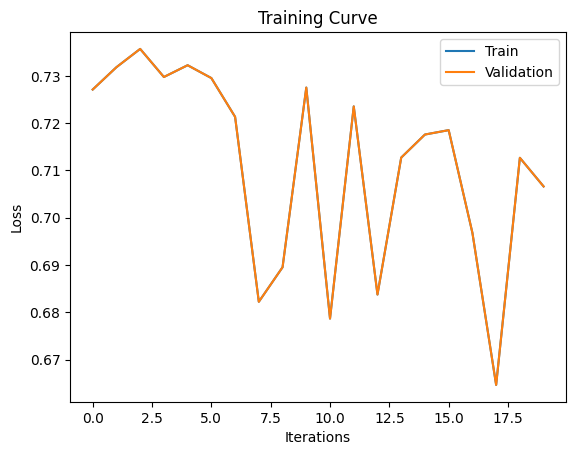

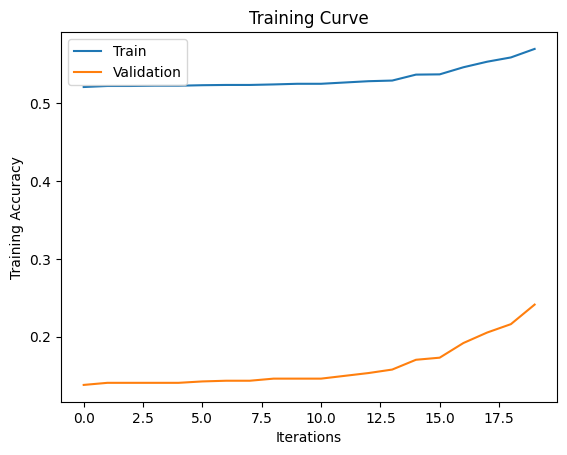

Final Training Accuracy: 0.5695572873486984
Final Validation Accuracy: 0.24125560538116592


In [70]:
model2 = newRNN(input_size, 100, 2)
train(model2, train_data, valid_data, 64, 20, 1e-5)

In [71]:
#reducing lr impacts the accuracy of the model. The validation accuracy begins to fall at about 10 epochs.

#try third alternative of returning the RNN output:
'''
class newerRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_class):
    self.name = "newerRNN"
    super(newerRNN, self).__init__()
    # one-hot encoding with length of input
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)
  # forward passing function
  def forward(self, x):
    # Look-up the embeddings
    x = self.emb[x]
    # Set the initial hidden states
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = torch.cat([torch.max(out, dim=1)[0],
                    torch.mean(out, dim=1)], dim=1)
    return self.fc(out)
'''
#edit: couldn't get it to work, so only using max-pooling RNN and regular RNN

'\nclass newerRNN(nn.Module):\n  def __init__(self, input_size, hidden_size, num_class):\n    self.name = "newerRNN"\n    super(newerRNN, self).__init__()\n    # one-hot encoding with length of input\n    self.emb = torch.eye(input_size)\n    self.hidden_size = hidden_size\n    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)\n    self.fc = nn.Linear(hidden_size, num_class)\n  # forward passing function\n  def forward(self, x):\n    # Look-up the embeddings\n    x = self.emb[x]\n    # Set the initial hidden states\n    h0 = torch.zeros(1, x.size(0), self.hidden_size)\n    out, _ = self.rnn(x, h0)\n    out = torch.cat([torch.max(out, dim=1)[0],\n                    torch.mean(out, dim=1)], dim=1)\n    return self.fc(out)\n'

Epoch 1: Train acc: 0.4800198971978113, Train loss: 0.6682025790214539 |Validation acc: 0.8654708520179372, Validation loss: 0.6682025790214539
Epoch 2: Train acc: 0.8056707013762229, Train loss: 0.6793739199638367 |Validation acc: 0.9282511210762332, Validation loss: 0.6793739199638367
Epoch 3: Train acc: 0.9144420494113745, Train loss: 0.6811982989311218 |Validation acc: 0.8645739910313901, Validation loss: 0.6811982989311218
Epoch 4: Train acc: 0.8653622948101476, Train loss: 0.6878507137298584 |Validation acc: 0.7443946188340808, Validation loss: 0.6878507137298584
Epoch 5: Train acc: 0.8268943790416183, Train loss: 0.6843711733818054 |Validation acc: 0.6717488789237668, Validation loss: 0.6843711733818054
Epoch 6: Train acc: 0.9021721107610678, Train loss: 0.6737203598022461 |Validation acc: 0.831390134529148, Validation loss: 0.6737203598022461
Epoch 7: Train acc: 0.9394793566572708, Train loss: 0.661045253276825 |Validation acc: 0.9273542600896861, Validation loss: 0.66104525327

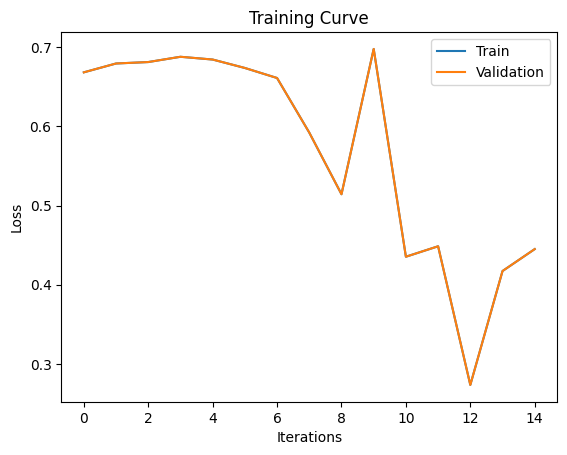

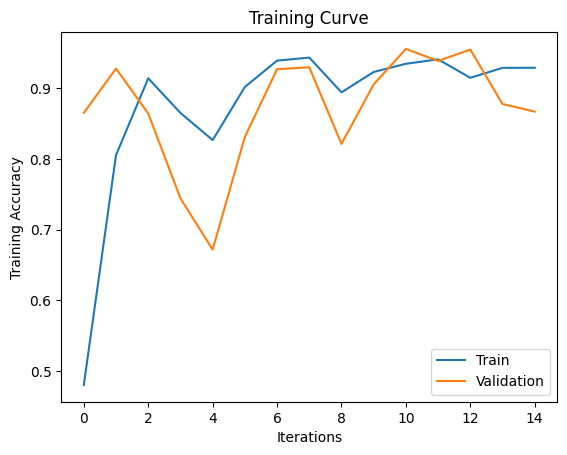

Final Training Accuracy: 0.9293649477698558
Final Validation Accuracy: 0.8672645739910314


In [72]:
#model3 = newerRNN(input_size, 100, 2)

#too much noise w/ lr = 5e-4, and accuracy drops at about 10-15 epochs, so decreasing
#epochs from 20 --> 15, increasing lr from 1e-5 --> 5e-5
model2 = newRNN(input_size, 100, 2)
train(model2, train_data, valid_data, 64, 15, 5e-5)

Epoch 1: Train acc: 0.4980931852097496, Train loss: 0.43725401163101196 |Validation acc: 0.8717488789237668, Validation loss: 0.43725401163101196
Epoch 2: Train acc: 0.9248880782623113, Train loss: 0.3322581648826599 |Validation acc: 0.9775784753363229, Validation loss: 0.3322581648826599
Epoch 3: Train acc: 0.923893218371746, Train loss: 0.07005888223648071 |Validation acc: 0.9802690582959641, Validation loss: 0.07005888223648071
Epoch 4: Train acc: 0.9602056043773836, Train loss: 0.16160713136196136 |Validation acc: 0.9704035874439462, Validation loss: 0.16160713136196136
Epoch 5: Train acc: 0.9534073951251866, Train loss: 0.026436861604452133 |Validation acc: 0.9829596412556054, Validation loss: 0.026436861604452133
Epoch 6: Train acc: 0.9724755430276902, Train loss: 0.029712075367569923 |Validation acc: 0.9811659192825112, Validation loss: 0.029712075367569923
Epoch 7: Train acc: 0.9703200132647986, Train loss: 0.07079870998859406 |Validation acc: 0.9730941704035875, Validation los

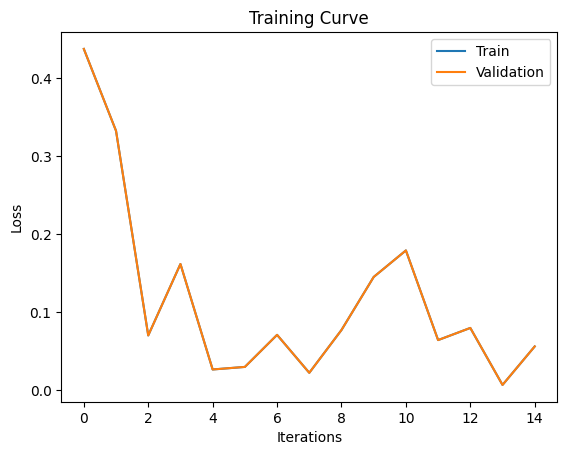

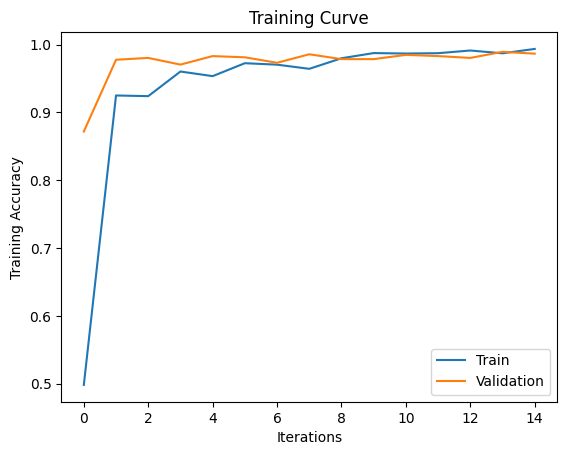

Final Training Accuracy: 0.9935334107113248
Final Validation Accuracy: 0.9865470852017937


In [102]:
#more consisten accuracy curve; try batch size: 64 --> 32, try 1st RNN again; try hidden layer size: 100 --> 200
model3 = newRNN(input_size, 200, 2)
train(model3, train_data, valid_data, 64, 15, 1e-3)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [103]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid_data.examples if e.label == 1],
    valid_data.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid_data.examples if e.label == 0],
    valid_data.fields) # TODO

#LOAD NON-SPAM & SPAM TO USE IN ACCURACY FUNCTION; FP --> 0s, FN --> 1s

#valid_zeroes = torchtext.data.BucketIterator(valid_nospam,
 #                                          batch_size=32,
  #                                         sort_key=lambda x: len(x.sms),
   #                                        sort_within_batch=True,
    #                                       repeat=False)
#valid_ones = torchtext.data.BucketIterator(valid_spam,
 #                                          batch_size=32,
  #                                         sort_key=lambda x: len(x.sms),
   #                                        sort_within_batch=True,
    #                                       repeat=False)
print((1-get_accuracy(model3, valid_nospam))*100, '% is the False Positive rate of the model.')
print((1-get_accuracy(model3, valid_spam))*100, '% is the False Negative rate of the model.')
#print(valid_data.examples)

0.5181347150259086 % is the False Positive rate of the model.
6.666666666666665 % is the False Negative rate of the model.


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [104]:
# A case of a false positive in this case means that a non-spam message will be flagged inaccurately as a spam message
# which can be problematic. Similarly, a high false negative means that the model's performance at labelling spam
# text messages is poor and will possibly label them as normal text messages.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [105]:
test_acc = get_accuracy(model3, test_data)
print('The model has a', test_acc*100, '% accuracy on testing data.')

The model has a 98.56373429084381 % accuracy on testing data.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [106]:
test_spam = torchtext.data.Dataset(
    [e for e in test_data.examples if e.label == 1],
    valid_data.fields)
test_nospam = torchtext.data.Dataset(
    [e for e in test_data.examples if e.label == 0],
    valid_data.fields)
print((1-get_accuracy(model3, test_nospam))*100, '% is the False Positive rate of the model across the test set.')
print((1-get_accuracy(model3, test_spam))*100, '% is the False Negative rate of the model across the test set.')

0.6217616580310836 % is the False Positive rate of the model across the test set.
7.38255033557047 % is the False Negative rate of the model across the test set.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [107]:
msg = "machine learning is sooo cool!"

# get index of every character by iterating through the message and passing .stoi:
idx_arr = []
for i in range(len(msg)):
  idx_arr.append(text_field.vocab.stoi[msg[i]])
# turn it into a row tensor to be able to pass through the model
msgg = torch.LongTensor([idx_arr])
model_prediction = model3(msgg)
prob = F.softmax(model_prediction, dim=1)
print("Probability the message is spam, using the best-performing model:", float(prob[0][1]*100), "%")

Probability the message is spam, using the best-performing model: 1.5784627199172974 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [108]:
# Detecting spam is a difficult task to do. Sites that send spam messages try to conceal the message's intentions in order to trick people into clicking whatever
# link/phish they are trying to promote. One model that can be used to detect spam and compare to my RNN is an SVM model.

# Using this model, you can first normalize the data entries (sentences) by removing unimportant characters like symbols, URLs, HTML tags, whitespace, etc. This
# will allow the model to more easily identify spam. Next, tokenize each word, and employ one-hot encoding so that each token has its own vector. Now, we can
# extract the features in R^n space. Then apply SVM classifier to predict a spam message or non-spam message.